## 第十四章 误差修正、伪回归和协整

### 表14.1 线性回归两个独立的随机游走的统计信息

Granger和Newbold二人创立了以下时间序列信息生成过程（DGP）：

$$
y_t=\phi y_{t-1}+u_t \qquad u_t \sim i.i.d.(0, \sigma^2_u) \\
x_t=\phi^*x_{t-1}+v_t \qquad v_t \sim i.i.d.(0, \sigma^2_v)
$$

则$y_t$和$x_t$是不相关的一阶自回归过程。 由于$x_t$既不会影响$y_t$，也不会受到$y_t$的影响，因此应该希望回归模型中的系数$\beta_1$：

$$
y_t=\beta_0+\beta_1x_t+\epsilon_t
$$

会收敛到零，反映出这两个系列之间没有任何关系，正如该回归的$R^2$统计量一样。

当$\phi=\phi^*=1$时，两个序列为随机游走序列。这时我们对两序列的统计量t和$R^2$进行计算。

$$
t = \frac{|\hat{\beta}_1|}{se(\hat{\beta}_1)}
$$

有关生成随机游走的代码如下：

In [1]:
import numpy as np


def random_walk(x0, sigma, const, n):
    a = np.random.normal(0, sigma, n)
    xt = np.zeros(n)
    xt[0] = x0
    for i in range(1, n):
        xt[i] = xt[i-1] + a[i] + const
    return xt

接下来对统计量进行计算，累计生成1000次，每次生成两个长度为50的随机游走序列，计算统计量区间出现的频次。

首先设置生成随机序列的参数：

In [2]:
import pandas as pd
import matplotlib.dates as mdate
import matplotlib.pyplot as plt
import scipy.stats as st
import warnings


warnings.filterwarnings('ignore')
np.random.seed(3)
nth = 1000
n = 50
count1 = count2 = 0
tlist, rlist, tcolumn, rcolumn = [[] for _ in range(4)]
tcal, rcal = [np.zeros(10) for _ in range(2)]
col = np.full(10, '')

循环生成1000次，并将每次的结果保存到列表中：

In [3]:
for i in range(nth):
    x = random_walk(0, 1, 0, n)
    y = random_walk(0, 1, 0, n)
    slope, intercept, r_value, p_value, std_err = st.linregress(x, y)
    temp1 = np.sum(np.power(y-slope*x-intercept, 2))/(n-2)
    temp2 = np.sum(np.power(x - np.mean(x), 2))
    se = np.sqrt(temp1/temp2)
    t = np.abs(slope)/se
    tlist.append(int(t/2))
    rlist.append(int(np.power(r_value, 2)*10))

分别对每个区间的频数进行统计：

In [4]:
for j in range(9):
    tcal[j] = tlist.count(j)
    rcal[j] = rlist.count(j)
    tcolumn.append(str(j * 2) + '-' + str(2 * (j + 1)))
    rcolumn.append(str(j / 10) + '-' + str((j + 1)/10))
for j in range(len(tlist)):
    if tlist[j] > 8:
        count1 += 1
    if rlist[j] > 8:
        count2 += 1
tcal[9], rcal[9] = count1, count2
tcolumn.append('>18')
rcolumn.append('0.9-1.0')

利用pandas将每个区间的结果打印出来：

In [5]:
df = np.append(np.append(tcolumn, tcal), np.append(rcolumn, rcal)).reshape([4, 10])
df = pd.DataFrame(df, index=['t-Statistics', '', 'R2 Statistics', ''], columns=col)
print(df)

                                                                              \
t-Statistics       0-2      2-4      4-6      6-8     8-10    10-12    12-14   
                 339.0    250.0    180.0    114.0     56.0     28.0     19.0   
R2 Statistics  0.0-0.1  0.1-0.2  0.2-0.3  0.3-0.4  0.4-0.5  0.5-0.6  0.6-0.7   
                 382.0    146.0    125.0     92.0     86.0     64.0     53.0   

                                          
t-Statistics     14-16    16-18      >18  
                   3.0      7.0      4.0  
R2 Statistics  0.7-0.8  0.8-0.9  0.9-1.0  
                  37.0     14.0      1.0  


### 图14.1 两个 I(0) 序列的相关系数的频数统计

u和v为白噪音序列，遵循标准正态分布。

现在要计算两个序列的皮尔逊相关系数，具体的实现代码如下：


In [6]:
def multipl(a, b):
    sumofab = 0.0
    for i in range(len(a)):
        temp = a[i] * b[i]
        sumofab += temp
    return sumofab


def corrcoef(x, y):
    n = len(x)
    sum1 = sum(x)
    sum2 = sum(y)
    sumofxy = multipl(x, y)
    sumofx2 = sum([pow(i, 2) for i in x])
    sumofy2 = sum([pow(j, 2) for j in y])
    num = sumofxy - (float(sum1) * float(sum2) / n)
    den = np.sqrt((sumofx2 - float(sum1 ** 2) / n) * (sumofy2 - float(sum2 ** 2) / n))
    return num / den

现在将两个序列生成1000次，每个序列的长度为100。统计皮尔逊相关系数的出现频次。

首先生成u、v两个序列：

In [7]:
np.random.seed(2)
n = 1000
t = 100
plist = []
for i in range(n):
    u = np.random.normal(0, 1, t)
    v = np.random.normal(0, 1, t)
    s = corrcoef(u, v)
    plist.append(s)

画出对应的频数图

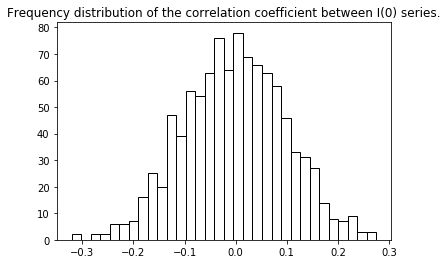

In [8]:
plt.figure()
plt.hist(plist, bins=32, facecolor="w", edgecolor="black")
plt.title('Frequency distribution of the correlation coefficient between I(0) series.')
plt.show()

### 图14.2 两个 I(1) 序列的相关系数的频数统计

x,y为两个随机游走序列，现在将两个序列生成1000次，每个序列的长度为100。统计皮尔逊相关系数的出现频次。

首先生成x、y两个序列：

In [9]:
np.random.seed(2)
n = 1000
t = 100
plist = []
for i in range(n):
    x = random_walk(0, 1, 0, t)
    y = random_walk(0, 1, 0, t)
    s = corrcoef(x, y)
    plist.append(s)

画出对应的频数图

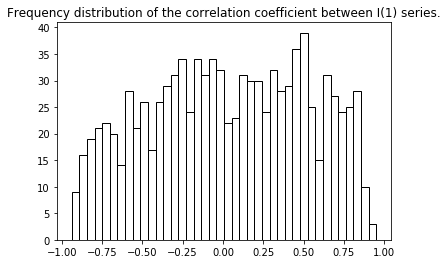

In [10]:
plt.figure()
plt.hist(plist, bins=40, facecolor="w", edgecolor="black")
plt.title('Frequency distribution of the correlation coefficient between I(1) series.')
plt.show()

### 图14.3 两个 I(2) 序列的相关系数的频数统计

z、w为两个AR(2)，现在将两个序列生成1000次，每个序列的长度为100。统计皮尔逊相关系数的出现频次。

首先代码实现AR函数：

In [11]:
def autoregressive(phi, sigma, x0, const, n):
    k = len(phi)
    xt = np.zeros(n)
    a = np.random.normal(0, sigma, n)
    for i in range(k):
        xt[i] = x0[i]
    for i in range(k, n):
        temp = 0
        for t in range(k):
            temp += phi[t] * xt[i-t-1]
        xt[i] = temp + a[i] + const
    return xt

生成z、w两个序列：

In [12]:
np.random.seed(2)
n = 1000
t = 100
plist = []
for i in range(n):
    z = autoregressive([2, -1], 1, [0, 0], 0, t)
    w = autoregressive([2, -1], 1, [0, 0], 0, t)
    s = corrcoef(z, w)
    plist.append(s)

画出对应的频数图

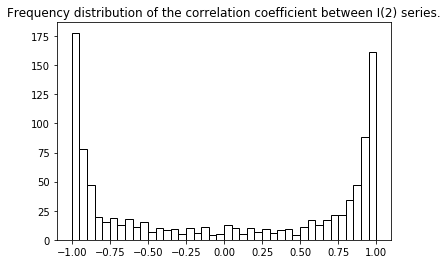

In [13]:
plt.figure()
plt.hist(plist, bins=40, facecolor="w", edgecolor="black")
plt.title('Frequency distribution of the correlation coefficient between I(2) series.')
plt.show()

### 图14.3 I(1)和I(2) 序列的相关系数的频数统计

x为随机游走序列，z为AR(2)，现在将两个序列生成1000次，每个序列的长度为100。统计皮尔逊相关系数的出现频次。

首先生成z、x两个序列：

In [14]:
np.random.seed(2)
n = 1000
t = 100
plist = []
for i in range(n):
    z = autoregressive([2, -1], 1, [0, 0], 0, t)
    x = random_walk(0, 1, 0, t)
    s = corrcoef(z, x)
    plist.append(s)

画出对应的频数图

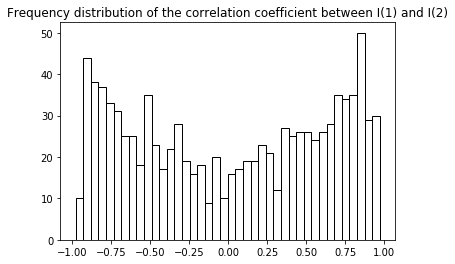

In [15]:
plt.figure()
plt.hist(plist, bins=40, facecolor="w", edgecolor="black")
plt.title('Frequency distribution of the correlation coefficient between I(1) and I(2)')
plt.show()

### 图14.3 I(0)和I(1) 序列的相关系数的频数统计

y为随机游走序列，v为白噪音，现在将两个序列生成1000次，每个序列的长度为100。统计皮尔逊相关系数的出现频次。

首先生成y、v两个序列：

In [16]:
np.random.seed(2)
n = 1000
t = 100
plist = []
for i in range(n):
    y = random_walk(0, 1, 0, t)
    v = np.random.normal(0, 1, t)
    s = corrcoef(y, v)
    plist.append(s)

画出对应的频数图

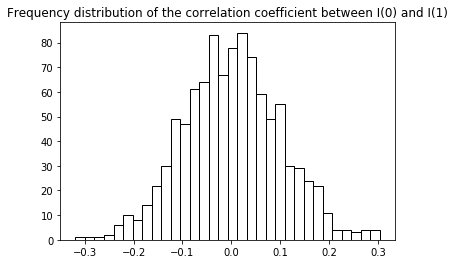

In [17]:
plt.figure()
plt.hist(plist, bins=32, facecolor="w", edgecolor="black")
plt.title('Frequency distribution of the correlation coefficient between I(0) and I(1)')
plt.show()

### 例14.1 英国利率是否为协整关系？

考虑到协整在具有集成变量的回归模型中所起的关键作用，测试其存在显然很重要。 检验可以基于协整回归的残差：

$$
\hat{e}_t=y_t-\hat{\beta}_0-\hat{\beta}_1x_{1,t}-...-\hat{\beta}_Mx_{M,t}
$$

这种基于残差的过程试图用单位根检验来检验没有协整的零假设。

ARDL模型的条件错误校正（CEC）形式为：

$$
\nabla y_t=\alpha_0+\alpha_1t-\phi(1)y_{t-1}+\sum_{j=1}^M\beta_j(1)x_{j,t-1}+\phi^*(B)\nabla y_{t-1}+\sum_{j=0}^M\gamma_j(B)\nabla x_{j,t}+a_t
$$

尽管上式是CEC的一般形式，但是有几种方法可以使常数和趋势进入误差校正。 例如，可以使$\alpha_0=\alpha_1=0$，得到以下的化简形式：

$$
\nabla y_t=-\phi(1)ec_{t-1}+\phi^*(B)\nabla y_{t-1}+\sum_{j=0}^M\gamma_j(B)\nabla x_{j,t}+a_t
$$

其中：

$$
ec_t=y_t-\sum_{j=1}^M\frac{\beta_j(1)}{\phi(1)}x_{j,t}
$$

在本题中，选取R20和RS的数据，分别进行回归。其中残差的关系如下：

$$
\hat{e}_{1,t}=R20_t-\hat{\beta}_0-\hat{\beta}_1RS_t \\
\hat{e}_{2,t}=RS_t-\hat{\beta}_0^{'}-\hat{\beta}_1R20_t
$$

首先读取interest rates数据：

In [18]:
data = pd.read_csv('data/interest_rates.csv')
temp = data.iloc[:, 0]
t = pd.to_datetime(data.iloc[:, 0], format='%Y-%m-%d')
r20 = np.array(data.iloc[:, 1])
rs = np.array(data.iloc[:, 2])

将R20与RS数据进行回归，得到以下结果：

In [19]:
k1 = st.linregress(rs, r20)
k2 = st.linregress(r20, rs)
print(k1)
print(k2)

LinregressResult(slope=0.7988615802015735, intercept=2.437830758360362, rvalue=0.8822278137604712, pvalue=1.0694382037998232e-258, stderr=0.015226154071853432)
LinregressResult(slope=0.9742938384597102, intercept=-1.0051785009305378, rvalue=0.8822278137604712, pvalue=1.0694382037998232e-258, stderr=0.01856986049060193)
